In [1]:
import os
import sys

import polars as pl
import numpy as np
from tqdm import tqdm
from datetime import date, timedelta, datetime, timezone

from binance_utility.plot_utils import plot_correlation

In [2]:
days = 30
symbol = "BTCUSDT"

last_date = date(year=2023, month=3, day=31)
#last_date = (datetime.now(timezone.utc) - timedelta(days = 2)).date()
start_date = last_date - timedelta(days=days)

df_trades = None

date_cursor = start_date
while date_cursor <= last_date:
    if df_trades is None:
        df_trades = pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet")
    else:
        df_trades = df_trades.vstack(pl.read_parquet(f"/home/jovyan/work/binance_utility/data/{symbol}_TRADES_{date_cursor.year:04d}-{date_cursor.month:02d}-{date_cursor.day:02d}.parquet"))
    date_cursor = date_cursor + timedelta(days=1)

df_trades = df_trades.with_columns([(pl.when(pl.col("side") == "a").then(-pl.col("qty")).otherwise(pl.col("qty"))).alias("qty")]).sort("timestamp")
df_trades.describe()

describe,symbol,timestamp,first_update_id,last_update_id,side,update_type,price,qty,pu
str,str,f64,f64,f64,str,str,f64,f64,f64
"""count""","""171546527""",1.71546527e8,1.71546527e8,1.71546527e8,"""171546527""","""171546527""",1.71546527e8,1.71546527e8,1.71546527e8
"""null_count""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0,0.0,0.0
"""mean""",null,1.6791e12,3.4347e9,3.4347e9,null,null,25367.05838,0.000011,3.4347e9
"""std""",null,6.7370e8,4.9665e7,4.9665e7,null,null,2740.82341,0.617196,4.9665e7
"""min""","""BTCUSDT""",1.6776e12,3.3487e9,3.3487e9,"""a""","""trade""",19521.6,-694.38,3.3487e9
"""max""","""BTCUSDT""",1.6803e12,3.5206e9,3.5206e9,"""b""","""trade""",29184.8,526.769,3.5206e9
"""median""",null,1.6791e12,3.4348e9,3.4348e9,null,null,26457.8,0.001,3.4348e9
"""25%""",null,1.6787e12,3.3916e9,3.3916e9,null,null,23043.3,-0.02,3.3916e9
"""75%""",null,1.6796e12,3.4777e9,3.4777e9,null,null,27798.6,0.02,3.4777e9


In [3]:
groupby_interval_min = 15
groupby_interval = groupby_interval_min * 60 * 1000

df_timebar = df_trades.groupby_dynamic("timestamp", every=f"{int(groupby_interval)}i", closed="left").agg([pl.col("price").first().alias("open"), pl.col("price").max().alias("high"), pl.col("price").min().alias("low"),pl.col("price").last().alias("close"), pl.col("qty").sum().alias("qty_sum")])
df_timebar = df_timebar.with_columns([((pl.col("close") - pl.col("open")) / pl.col("open")).alias("pct_change")])

argument is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


_popt[0] = 0.130342755277474
_popt[1] = 0.012212495973038199


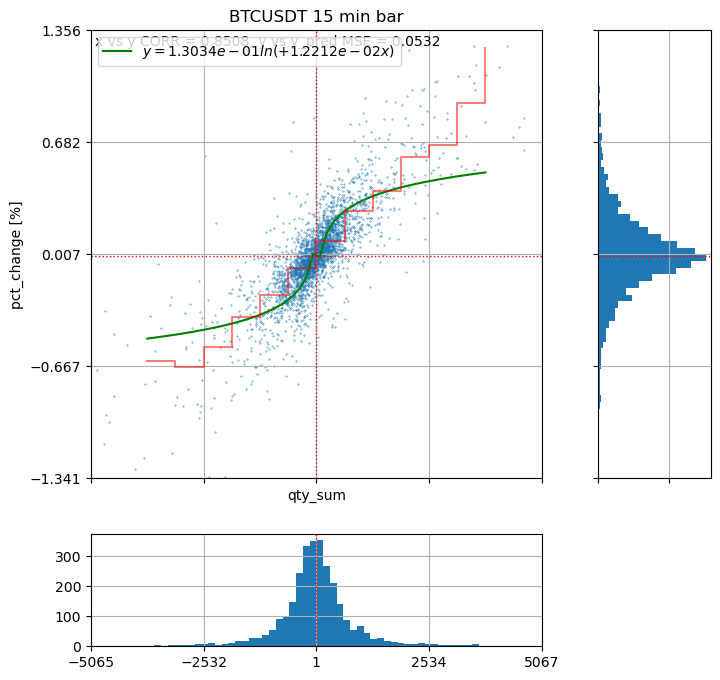

In [5]:
x = df_timebar["qty_sum"]
y = df_timebar["pct_change"] * 100

def func(x, a, b):
    return np.where(np.abs(x) < 1, 0, np.sign(x) * a * np.log(np.abs(b * x)))
func_str = "$y = %s ln(%s x)$"

plot_correlation(x, y, func=func, func_label=func_str, title=f"{symbol} {groupby_interval_min} min bar", xaxis_label="qty_sum", yaxis_label="pct_change [%]", legend_loc="best")

0.0004986597040679726


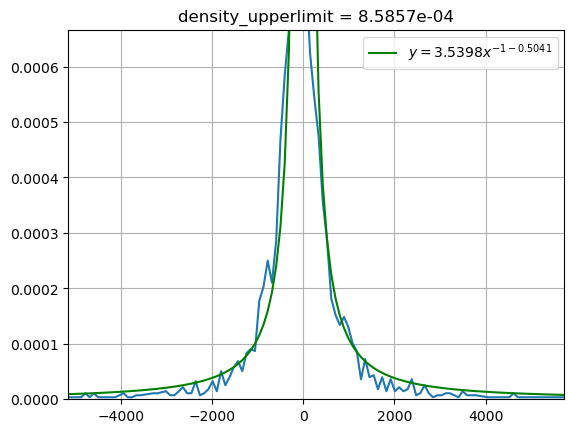

In [6]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_quantile = 0.97
density_upperlimit = np.quantile(array_histogram[0], density_quantile)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)
print(density_upperlimit)


def func(x, a, b):
    return a * np.power(np.abs(x), -1+b)
    
_popt, _pcov = curve_fit(func, df_histogram["qty_sum"], df_histogram["density"])

array_histogram = np.histogram(df_timebar["qty_sum"], bins=256, density=True)
density_upperlimit = np.quantile(array_histogram[0], 1.0)
df_histogram = pl.DataFrame({"qty_sum": array_histogram[1][:-1], "density": array_histogram[0]}).filter(pl.col("density") > 0).filter(pl.col("density") < density_upperlimit)
plt.plot(df_histogram["qty_sum"], df_histogram["density"])
plt.plot(df_histogram["qty_sum"], func(df_histogram["qty_sum"], *_popt), color = 'green', label = '$y = %s x^{-1%s}$' % (f'{_popt[0]:.4f}',  f'{_popt[1]:+.4f}'))

plt.ylim(0, df_histogram["density"].quantile(0.97))
plt.xlim(df_histogram["qty_sum"].quantile(0.1), df_histogram["qty_sum"].quantile(0.9))
plt.title(f"density_upperlimit = {density_upperlimit:.4e}")
plt.grid()
plt.legend()

In [6]:
minmax_check_start = 1
minmax_check_end = 5

df_big_change = df_groupby_dynamic.filter(pl.col("pct_change").abs() > 0.025 / 100)
print(df_big_change.shape)
df_big_change_minmax = pl.DataFrame({"timestamp": [], "max_in_xmin": [], "min_in_xmin": []}, schema={"timestamp": pl.Int64, "max_in_xmin": pl.Float64, "min_in_xmin": pl.Float64})

for _row in tqdm(df_big_change.iter_rows()):
    _df_groupby_dynamic = df_groupby_dynamic.filter((pl.col("timestamp") >= _row[0] + groupby_interval * (1 + minmax_check_start)) & (pl.col("timestamp") < _row[0] + groupby_interval * (minmax_check_end + 1)))
    if len(_df_groupby_dynamic) == 0:
        continue
    _max = _df_groupby_dynamic.select(pl.max("high"))[0, 0] / _row[2] - 1.0
    _min = _df_groupby_dynamic.select(pl.min("low"))[0, 0] / _row[2] - 1.0


    df_big_change_minmax = df_big_change_minmax.vstack(pl.DataFrame({"timestamp": [_row[0]], "max_in_xmin": [_max], "min_in_xmin": [_min]}, schema={"timestamp": pl.Int64, "max_in_xmin": pl.Float64, "min_in_xmin": pl.Float64}))

df_big_change = df_big_change.join(df_big_change_minmax, on="timestamp", how="left").drop_nulls()

(5409, 7)


5409it [00:10, 504.77it/s] 


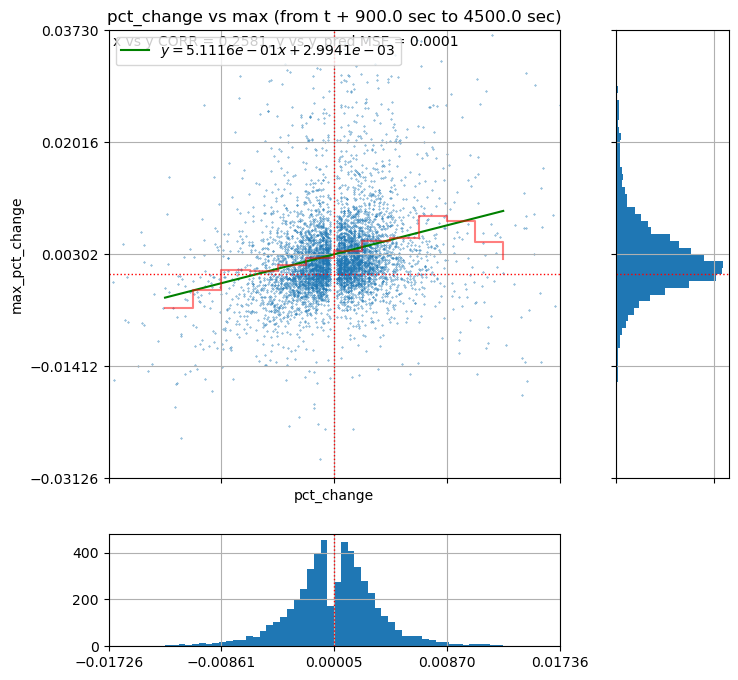

In [7]:
x = df_big_change["pct_change"]
y = df_big_change["max_in_xmin"]

plot_correlation(x, y, title=f"pct_change vs max (from t + {minmax_check_start * groupby_interval / 1000} sec to {minmax_check_end * groupby_interval / 1000} sec)", xaxis_label="pct_change", yaxis_label="max_pct_change", legend_loc="upper left")

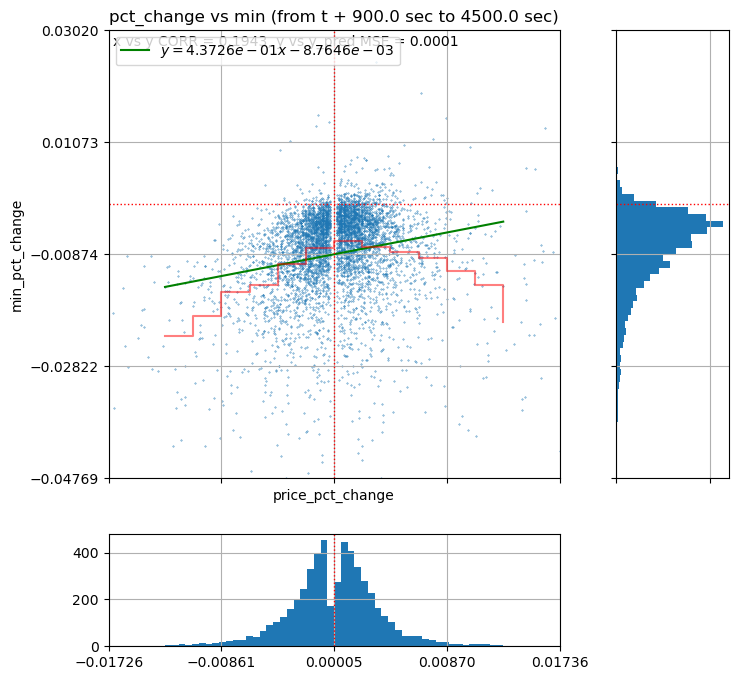

In [10]:
x = df_big_change["pct_change"]
y = df_big_change["min_in_xmin"]

plot_correlation(x, y, title=f"pct_change vs min (from t + {minmax_check_start * groupby_interval / 1000} sec to {minmax_check_end * groupby_interval / 1000} sec)", xaxis_label="price_pct_change", yaxis_label="min_pct_change", legend_loc="upper left")

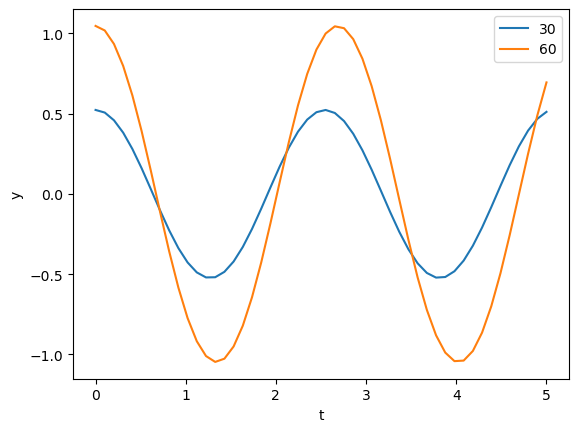

In [49]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# exp
#def f(x, y, a):
#    return a * y
#
#def ode_system(x, y, a):
#    return [f(x, y[0], a)]

# 振り子
def f(t, y):
    x = y[0]
    v = y[1]
    F0 = v
    F1 = -4*np.pi**2*np.sin(x)
    return [F0, F1]
    
# Parameters
x_span = [0.0, 2.0]

# Solve the ODE using the 'Radau' method
y0 = [np.pi / 180 * 30, 0]
sol_30 = solve_ivp(f, x_span, y0, method='Radau', dense_output=True, rtol = 1.e-12, atol = 1.e-12)

# Solve the ODE using the 'Radau' method
y0 = [np.pi / 180 * 60, 0]
sol_60 = solve_ivp(f, x_span, y0, method='Radau', dense_output=True, rtol = 1.e-12, atol = 1.e-12)

# Evaluate the solution at specific time points
x_values = np.linspace(x_span[0], x_span[-1], 50)
y_values = sol_30.sol(x_values)
y2_values = sol_60.sol(x_values)

# Plot the results
plt.plot(t_values, y_values[0], label='30')
plt.plot(t_values, y2_values[0], label='60')
plt.xlabel('t')
plt.ylabel('y')
plt.legend()
plt.show()

: 